## CAMD Meta agent example

In [1]:
from camd.campaigns.meta_agent import MetaAgentCampaign, \
    StabilityCampaignAnalyzer
from camd.analysis import StabilityAnalyzer
from camd.utils.data import load_dataframe, partition_intercomp, \
    get_oqmd_data_by_chemsys
from camd.experiment.agent_simulation import LocalAgentSimulation
from camd.agent.base import RandomAgent
from taburu.table import ParameterTable
from camd import CAMD_S3_BUCKET
# Note that env variable must be set
if CAMD_S3_BUCKET is None:
    raise ValueError("Set CAMD_S3_BUCKET to enable notebook")

### Define the agents and agent_pool

In [3]:
# Define agent parameters
agent_params = [
    {
        "@class": ["camd.agent.base.RandomAgent"],
        "n_query": [2, 3],
    },
]

### Construct the dataframe using Fe-O data

In [2]:
data = get_oqmd_data_by_chemsys("Fe-O", drop_duplicates=True)
candidate_data, seed_data = partition_intercomp(data)

### Construct core campaign objects

In [4]:
experiment = LocalAgentSimulation(
    atf_candidate_data=candidate_data, seed_data=seed_data,
    analyzer=StabilityAnalyzer(), iterations=10,
)
analyzer = StabilityCampaignAnalyzer(
    checkpoint_indices=[2, 5, 10])
agent_pool = ParameterTable(agent_params)

100%|██████████| 2/2 [00:00<00:00, 5966.29it/s]


### Reserve campaign in S3

In [5]:
MetaAgentCampaign.reserve(
    name="test_meta_agent_python", experiment=experiment,
    agent_pool=agent_pool, analyzer=analyzer
)

### Run via Python API

MetaAgentCampaign initialization state: Agent RandomAgent hypothesizing
MetaAgentCampaign 0 state: Running experiments
Iteration: 0
MetaAgentCampaign 0 state: Getting new results
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results


/Users/josephmontoya/miniconda3/envs/camd/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing results
Campaign 4 state: Agent RandomAgent hypothesizing
Campaign 4 state: Running experiments
  Waiting for next round ...
Iteration: 5
Campaign 5 state: Getting new results
Campaign 5 state: Analyzing results
Campaign 5 state: Agent RandomAgent hypothesizing
Campaign 5 state: Running experiments
  Waiting for next round ...
Iteration: 6
Campaign 6 state: Getting new results
Campaign 6 state

/Users/josephmontoya/PycharmProjects/camd/camd_public/camd/analysis.py:365: UserWarning: No prior data, prior phase diagram cannot be constructed
  warnings.warn("No prior data, prior phase diagram cannot be constructed")


MetaAgentCampaign 0 state: Analyzing results
MetaAgentCampaign 0 state: Agent RandomAgent hypothesizing
MetaAgentCampaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
MetaAgentCampaign 1 state: Getting new results
Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new resu

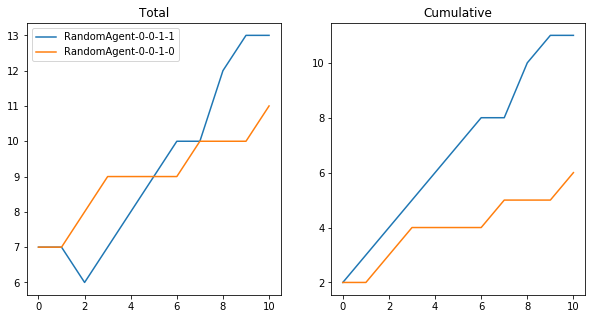

In [6]:
import os
os.mkdir('python')
os.chdir('python')
meta_agent = RandomAgent(n_query=1)
campaign = MetaAgentCampaign.from_reserved_name(
    "test_meta_agent_python", meta_agent=meta_agent)
campaign.autorun()
os.chdir('..')

### Run via CLI

In [8]:
def create_test(name):
    data = get_oqmd_data_by_chemsys("Fe-O", drop_duplicates=True)
    candidate_data, seed_data = partition_intercomp(data)
    experiment = LocalAgentSimulation(
        atf_candidate_data=candidate_data, seed_data=seed_data,
        analyzer=StabilityAnalyzer(), iterations=10,
    )
    analyzer = StabilityCampaignAnalyzer(
        checkpoint_indices=[2, 5, 10])
    agent_pool = ParameterTable(agent_params)
    MetaAgentCampaign.reserve(
        name=name, experiment=experiment,
        agent_pool=agent_pool, analyzer=analyzer
    )

In [ ]:
create_test("test_meta_agent_cli")

In [ ]:
# Run s3 backed campaign
!rm -rf test && \
mkdir test && \
cd test && \
camd_runner meta_agent/test_meta_agent_cli

Summary figure
![title](test/campaign_summary.png)

### Run on AWS Batch

In [9]:
create_test("test_meta_agent_aws_batch")

100%|██████████| 2/2 [00:00<00:00, 3545.48it/s]


In [10]:
submit_output = \
!aws batch submit-job \
--job-name test_meta_agent_aws_batch \
--job-queue camd_dev \
--job-definition camd_dev_batch \
--parameters name=meta_agent/test_meta_agent_aws_batch

In [12]:
import json, time
job_data = json.loads(''.join(submit_output))
job_id = job_data['jobId']
while True:
    describe_output = !aws batch describe-jobs --jobs $job_id
    job_data = json.loads(''.join(describe_output))
    job_status = job_data['jobs'][0]['status']
    print("Job status is {}".format(job_status))
    if job_status not in ['PENDING', 'RUNNABLE', 'RUNNING']:
        break
    time.sleep(20)

Job status is RUNNABLE
Job status is RUNNABLE
Job status is RUNNABLE
Job status is STARTING
